In [1]:
import os
import torch
import math
import json
import random
import numpy as np
import torch.nn as nn
import trackio
import transformers
from PIL import Image
from torchvision import datasets
from dataclasses import dataclass
from typing import List, Dict, Any
from torch.utils.data import DataLoader, random_split
from transformers import AutoImageProcessor, AutoModel, AutoConfig, get_cosine_schedule_with_warmup

In [2]:
class DinoV3Linear(nn.Module):
    def __init__(self, backbone: AutoModel, num_classes: int, freeze_backbone: bool = True):
        super().__init__()
        self.backbone = backbone
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
            self.backbone.eval()
        
        hidden_size = getattr(backbone.config, "hidden_size", None)
        self.head = nn.Linear(hidden_size, num_classes)

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        last_hidden = outputs.last_hidden_state
        cls = last_hidden[:, 0]
        logits = self.head(cls)
        return logits

In [3]:
data_dir = "./tennis/images"
full_dataset = datasets.ImageFolder(root=data_dir)
strokes = {
    0: "backhand_back",
    1: "backhand_front",
    2: "forehand_back",
    3: "forehand_front",
    4: "serve_front",
    5: "serve_back"
}

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

num_classes = len(full_dataset.classes)
id2label = {i: c for i, c in enumerate(full_dataset.classes)}
label2id = {c: i for i, c in id2label.items()}

In [4]:
MODEL_NAME = "dinov3-vitb16-pretrain-lvd1689m"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
backbone = AutoModel.from_pretrained(MODEL_NAME)
image_processor_config = json.loads(image_processor.to_json_string())
backbone_config = json.loads(AutoConfig.from_pretrained(MODEL_NAME).to_json_string())

freeze_backbone = True
model = DinoV3Linear(backbone, num_classes, freeze_backbone=freeze_backbone).to(device)

In [5]:
BATCH_SIZE = 8
NUM_WORKERS = 0
EPOCHS = 30
LR = 5e-4
WEIGHT_DECAY = 1e-4
WARMUP_RATIO = 0.05
CHECKPOINT_DIR = "./weights"
EVAL_EVERY_STEPS = 100

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

@dataclass
class Collator:
    processor: AutoImageProcessor

    def __call__(self, batch):
        # unpack (image, label) tuples
        images, labels = zip(*batch)

        rgb_images = [img.convert("RGB") if isinstance(img, Image.Image) else img for img in images]

        inputs = self.processor(images=rgb_images, return_tensors="pt")
        labels = torch.tensor(labels, dtype=torch.long)

        return {"pixel_values": inputs["pixel_values"], "labels": labels}
    
collate_fn = Collator(image_processor)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn,
)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
total_steps = EPOCHS * math.ceil(len(train_loader))
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
criterion = nn.CrossEntropyLoss()

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

C:\Users\walui\AppData\Local\Temp\ipykernel_453520\3431088428.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [6]:
def evaluate() -> Dict[str, float]:
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch["pixel_values"].to(device, non_blocking=True)
            labels = batch["labels"].to(device, non_blocking=True)
            logits = model(pixel_values)
            loss = criterion(logits, labels)
            loss_sum += loss.item() * labels.size(0)
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return {
        "val_loss": loss_sum / max(total, 1),
        "val_acc": correct / max(total, 1),
    }

In [7]:
best_acc = 0.0
global_step = 0

trackio.init(project="dinov3", config={
            "epochs": EPOCHS,
            "learning_rate": LR,
            "batch_size": BATCH_SIZE
        })

for epoch in range(1, EPOCHS + 1):
    model.train()
    model.backbone.eval()  

    running_loss = 0.0
    for i, batch in enumerate(train_loader, start=1):
        pixel_values = batch["pixel_values"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(pixel_values)
        loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item()
        global_step += 1

        if global_step % EVAL_EVERY_STEPS == 0:
            metrics = evaluate()
            print(
                f"[epoch {epoch} | step {global_step}] "
                f"train_loss={running_loss / EVAL_EVERY_STEPS:.4f} "
                f"val_loss={metrics['val_loss']:.4f} val_acc={metrics['val_acc']*100:.2f}%"
            )
            running_loss = 0.0

            if metrics["val_acc"] > best_acc:
                best_acc = metrics["val_acc"]
                ckpt_path = os.path.join(CHECKPOINT_DIR, f"model_best.pt")
                torch.save(
                    {
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "scheduler_state_dict": scheduler.state_dict(),
                        "config": {
                            "model_name": MODEL_NAME,
                            "classes": full_dataset.classes,
                            "backbone": backbone_config,
                            "image_processor": image_processor_config,
                            "freeze_backbone": freeze_backbone,
                        },
                        "step": global_step,
                        "epoch": epoch,
                    },
                    ckpt_path,
                )

    metrics = evaluate()
    trackio.log({
        "epoch": epoch,
        "val_loss": metrics['val_loss'],
        "val_acc": best_acc
    })
    
    print(
        f"END EPOCH {epoch}: val_loss={metrics['val_loss']:.4f} val_acc={metrics['val_acc']*100:.2f}% "
        f"(best_acc={best_acc*100:.2f}%)"
    )
trackio.finish()



* Trackio project initialized: dinov3
* Trackio metrics logged to: C:\Users\walui\.cache\huggingface\trackio


* Created new run: calm-river-2
END EPOCH 1: val_loss=1.4957 val_acc=56.60% (best_acc=0.00%)
[epoch 2 | step 100] train_loss=0.5963 val_loss=1.0265 val_acc=66.98%
END EPOCH 2: val_loss=1.0234 val_acc=66.04% (best_acc=66.98%)
END EPOCH 3: val_loss=0.7611 val_acc=80.19% (best_acc=66.98%)
[epoch 4 | step 200] train_loss=0.3038 val_loss=0.6615 val_acc=83.96%
END EPOCH 4: val_loss=0.6625 val_acc=79.25% (best_acc=83.96%)
END EPOCH 5: val_loss=0.5582 val_acc=87.74% (best_acc=83.96%)
[epoch 6 | step 300] train_loss=0.1812 val_loss=0.5108 val_acc=88.68%
END EPOCH 6: val_loss=0.5061 val_acc=87.74% (best_acc=88.68%)
END EPOCH 7: val_loss=0.4635 val_acc=87.74% (best_acc=88.68%)
[epoch 8 | step 400] train_loss=0.1275 val_loss=0.4475 val_acc=88.68%
END EPOCH 8: val_loss=0.4212 val_acc=91.51% (best_acc=88.68%)
END EPOCH 9: val_loss=0.4148 val_acc=88.68% (best_acc=88.68%)
[epoch 10 | step 500] train_loss=0.0849 val_loss=0.3973 val_acc=89.62%
END EPOCH 10: val_loss=0.3749 val_acc=88.68% (best_acc=89.62

In [8]:
trackio.show()

In [9]:
correct, total = 0, 0
with torch.no_grad():
    for img, label in train_dataset:
        inputs = image_processor(images=img, return_tensors="pt").to(device)
        logits = model(inputs["pixel_values"])
        probs = torch.softmax(logits, dim=-1)
        pred = probs.argmax(dim=-1).item()
        correct += int(pred == label)
        total += 1

accuracy = correct / total
print(f"Train Accuracy: {accuracy:.4f}")

Train Accuracy: 0.9741


In [10]:
correct, total = 0, 0
with torch.no_grad():
    for img, label in val_dataset:
        inputs = image_processor(images=img, return_tensors="pt").to(device)
        logits = model(inputs["pixel_values"])
        probs = torch.softmax(logits, dim=-1)
        pred = probs.argmax(dim=-1).item()
        correct += int(pred == label)
        total += 1

accuracy = correct / total
print(f"Val Accuracy: {accuracy:.4f}")

Val Accuracy: 0.9245


Example Prediction: serve_front, Label: serve_front


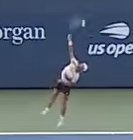

In [11]:
img0,label0=val_dataset[3]
inputs = image_processor(images=img0, return_tensors="pt").to(device)
logits = model(inputs["pixel_values"])
probs = torch.softmax(logits, dim=-1)
pred = probs.argmax(dim=-1).item()
print(f"Example Prediction: {strokes[pred]}, Label: {strokes[label0]}") 
img0

Example Prediction: forehand_back


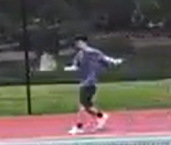

In [12]:
test1 = Image.open("./tennis/sc1.png").convert("RGB")
inputs = image_processor(images=test1, return_tensors="pt").to(device)
logits = model(inputs["pixel_values"])
probs = torch.softmax(logits, dim=-1)
pred = probs.argmax(dim=-1).item()
print(f"Example Prediction: {strokes[pred]}") 
test1

Example Prediction: forehand_back


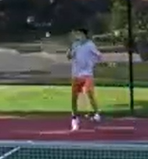

In [13]:
test2 = Image.open("./tennis/sc2.png").convert("RGB")
inputs = image_processor(images=test2, return_tensors="pt").to(device)
logits = model(inputs["pixel_values"])
probs = torch.softmax(logits, dim=-1)
pred = probs.argmax(dim=-1).item()
print(f"Example Prediction: {strokes[pred]}") 
test2

Example Prediction: forehand_front


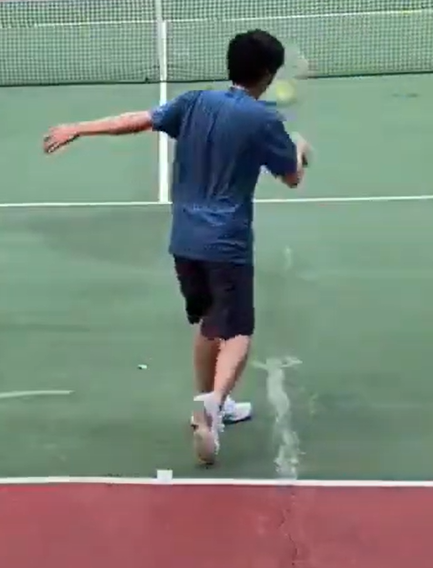

In [21]:
test3 = Image.open("./tennis/sc3.png").convert("RGB")
inputs = image_processor(images=test3, return_tensors="pt").to(device)
logits = model(inputs["pixel_values"])
probs = torch.softmax(logits, dim=-1)
pred = probs.argmax(dim=-1).item()
print(f"Example Prediction: {strokes[pred]}") 
test3